In [1]:
import pandas as pd
import scipy as sp
from scipy.stats import rankdata

import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGM
import numpy as np
import json
import networkx as nx
from scipy.stats import kendalltau, spearmanr, pearsonr
import community
from sklearn.cluster import KMeans
from matplotlib.pyplot import cm
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from datetime import datetime
import matplotlib
from tqdm import notebook as nb

from surprise import Dataset, Reader, SVD,accuracy
import pandas as pd
import scipy as sp
from scipy.stats import rankdata

from scipy.sparse import csr_matrix
from scipy import spatial

from sklearn.metrics import r2_score,explained_variance_score
import os
import pickle as pk
from pandas.api.types import CategoricalDtype
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from dateutil.relativedelta import relativedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange, YearLocator
import pickle


In [2]:
plot_width = 3.337
plot_height = plot_width / 1.618

# Data and Methods

## 2.1 Data Collection

Figure 1.
Frequency of the most typical recommendations (Left) and of the most typical outcomes (Right) in AfD discussions

Loading dataset votes_df.csv...

Filtering dataset...




Number of Voters:  20153 

Number of AfD discussions/articles:  355505 

Number of recommendations::  1495963 

Loading dataset outcomes_df.csv...



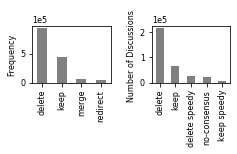

In [3]:
#Loading Data
print("Loading dataset votes_df.csv...\n")

vote = pd.read_csv('csv_files/data_CMU/votes_df.csv', index_col=False)
vote_df=vote[['vote_id','discussion_id','timestamp','user_id','label']]

vote_df= vote_df[vote_df['label'].isin(['keep','delete','merge','redirect'])]

vote_df.drop(vote_df[vote_df['timestamp']==-1].index, inplace=True)

#Filtering 
print("Filtering dataset...\n")
vote_df_filter = []
for n,grp in nb.tqdm(vote_df.groupby('user_id')):
    if grp['discussion_id'].count() >=5 :
        vote_df_filter.append(n)
vote_df2= vote_df[vote_df['user_id'].isin(vote_df_filter)]

print("Number of Voters: ",len(vote_df_filter),"\n")
print("Number of AfD discussions/articles: ",len(vote_df2['discussion_id'].unique()),"\n")
print("Number of recommendations:: ",len(vote_df2['vote_id'].unique()),"\n")



vote_df_frac=vote_df2.groupby('label').count().reset_index('label')

print("Loading dataset outcomes_df.csv...\n")

df_outcome= pd.read_csv('Data_Wiki_Workshop/pandas_afd/outcomes_df.csv', index_col=False)

df_outcome2=df_outcome[df_outcome['label'].isin(['delete','delete speedy','keep','keep speedy','no-consensus'])]


df_outcome2.head()
outcome_df_frac = df_outcome2['label'].value_counts().head(9)


#Plot
plt.rc('font',size=8)
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)



fig, axes = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(left=.15, bottom=.05, right=.99, top=.97,wspace = 0.4)

vote_df_frac.plot(kind='bar',x='label',y='user_id',
                      color = 'grey',
                     legend=False, ax=axes[0])
outcome_df_frac.plot(kind='bar',x='label',y='discussion_id',
                      color = 'grey',
                     legend=False,ax=axes[1])
ylabels = ["Frequency","Number of Discussions "]
i=0
for axe in axes:
    axe.ticklabel_format(axis='y', style='sci', scilimits=(5,5))
    axe.tick_params(axis='x', rotation=90)
    axe.set_xlabel('')
    axe.set_ylabel(ylabels[i])
    i +=1
    
    
fig.set_size_inches(plot_width, plot_height)
plt.tight_layout()
plt.show()

In [131]:
fig.savefig('Plot_Wiki_Workshop/Vote_and_Outcome_Distribution.pdf', dpi=150)

Figure 2. Complementary cumulative distribution of num-ber of recommendations per user.

Loading dataset data_vote_counts.csv...

Calculating CCDF...



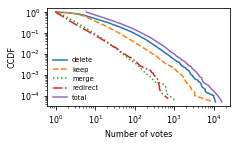

In [4]:
def ccdf_values(data):

    ccdf_dict={}
    for col in list(data.columns):
        values= data[col].sort_values()
        rank_data = data[col].sort_values().apply(lambda x: x*-1).rank()
        prob= rank_data/rank_data.max()
        ccdf_dict[col]=pd.DataFrame({"values": values.tolist(), "rank" : rank_data ,"prob": prob.tolist()})
        
    #ccdf_data = pd.DataFrame(ccdf_dict)
    return ccdf_dict



#Loading Data
print("Loading dataset data_vote_counts.csv...\n")
user_counts = pd.read_csv('Data_Wiki_Workshop/csv_files/data_vote_counts.csv', index_col=False)

user_counts=user_counts.drop(['user_id','alignment_score'], axis=1)

user_counts['total']=user_counts.sum(axis=1)

#ccdf calculation
print("Calculating CCDF...\n")

ccdf_data= ccdf_values(user_counts)

#Plot
plt.rc('font',size=8)
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

fig = plt.figure()
ax = plt.axes()
fig.subplots_adjust(left=.15, bottom=.05, right=.99, top=.97,wspace = 0.4)


for l,ls in zip(list(user_counts.columns),["-","--",":","-.","-"]):
    ax.plot(ccdf_data[l]["values"] +1 ,ccdf_data[l]["prob"], label = l, linestyle =ls)


# plt.ylim(1e-5, 2)    
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Number of votes')
ax.set_ylabel('CCDF')
plt.legend(frameon=False, fontsize='small')
# plt.rc("font", labelsize="small")

# plt.xlim(0.1, 26204)

# plt.title("Log plots of CCDF for user greater than Total counts 5 ")
fig.set_size_inches(plot_width, plot_height)
plt.tight_layout()
plt.show()

In [67]:
fig.savefig('Plot_Wiki_Workshop/CCDF.pdf', dpi=150)

## Measurement of Preference

Figure 3: Left: Bayessian Gaussian mixture model with 𝑘=4 components. Right: the model was selected using the Bayesian Information Criterion.

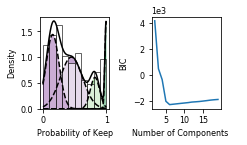

In [5]:
user_counts = pd.read_csv('Data_Wiki_Workshop/csv_files/data_vote_counts.csv', index_col=False)
data = user_counts[user_counts.columns[-1:]]


with open('Data_Wiki_Workshop/GMM_model_save.pickle', 'rb') as handle:
    model_save = pickle.load(handle)

with open('Data_Wiki_Workshop/em_lb.pickle', 'rb') as handle:
    em_lb = pickle.load(handle)    

# color_set = model_save.predict(data)

# labels = model_save.predict(data)

logprob = model_save.score_samples(data.sort_values(by=data.columns[0]))

pdf = np.exp(logprob)
responsibilities = model_save.predict_proba(data.sort_values(by=data.columns[0]))

pdf_individual = responsibilities * pdf[:, np.newaxis]



#Plot
plt.rc('font',size=8)
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)


m = ["","#7b3294",  "#c2a5cf", "#a6dba0","#008837" ]
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.subplots_adjust(left=.15, bottom=.05, right=.99, top=.97,wspace = 0.0005)

r=rankdata(model_save.means_).tolist()
n=4
  
axes[0].hist(data[data.columns[0]].sort_values(),histtype='bar',density=True, alpha =.6,ec='black',color="white" )
axes[0].plot(data[data.columns[0]].sort_values(), pdf, '-k')
axes[0].plot(data[data.columns[0]].sort_values(), pdf_individual, '--k')

for i in range(n):
     axes[0].fill_between(data[data.columns[0]].sort_values(), 0,pdf_individual[:,i], facecolor=m[int(r[i])], alpha = 1)

axes[0].set(xlabel="Probability of Keep", ylabel = "Density" 
         )  



axes[1].plot(range(2,len(em_lb)+2),em_lb)
axes[1].set(xlabel="Number of Components     ", ylabel="BIC")
axes[1].ticklabel_format(axis='y', style='sci', scilimits=(3,3))

fig.set_size_inches(plot_width, plot_height)
plt.tight_layout()
plt.show()

In [307]:
fig.savefig('Plot_Wiki_Workshop/Probability_keep_and_BIC.pdf', dpi=150)

## Results

### Correlation between edge and co-membership 

 Figure 6. Correlation between edge sign / weight and class co-membership for Bayesian Gaussian mixture model (GMM) and network communities (Louvain)

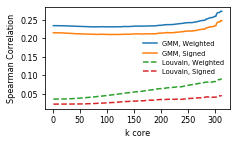

In [6]:
data_f= pd.read_csv('Data_Wiki_Workshop/csv_files/Correlations_all.csv', index_col=False)

plt.rc('font',size=8)
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.05, right=.99, top=.97,wspace = 0.002)

plt.plot(data_f['k_list_f'],data_f['corr_list_spe_gau_weight_f'], Label='GMM, Weighted')
plt.plot(data_f['k_list_f'],data_f['corr_list_spe_gau_sign_f'], Label='GMM, Signed')

plt.plot(data_f['k_list_f'],data_f['corr_list_spe_mod_weight_f'], '--' ,Label='Louvain, Weighted')
plt.plot(data_f['k_list_f'],data_f['corr_list_spe_mod_sign_f'], '--' ,Label='Louvain, Signed')
plt.xlabel("k core")
plt.ylabel("Spearman Correlation")
plt.legend(frameon=False, fontsize='small')

fig.set_size_inches(plot_width, plot_height)
plt.tight_layout()
plt.show()

In [135]:
fig.savefig('Plot_Wiki_Workshop/Correlation_vs_Kcore.pdf', dpi=150)

### K-shell and Cohorts 

Figure 7: Left: Distribution of 𝑘-shell values for bi-yearly cohorts of editors who started taking part to AfD discussions in the same period. The drop in 𝑘-shell after 2008 suggests that the core of the network is composed of older usersfrom prior cohorts. Right: Cohort size over time. Each dot corresponds to the number of editors who started takingpart to AfD discussion in that year or the following.


2005-01-01 00:00:00 2007-01-01 00:00:00
2007-01-01 00:00:00 2009-01-01 00:00:00
2009-01-01 00:00:00 2011-01-01 00:00:00
2011-01-01 00:00:00 2013-01-01 00:00:00
2013-01-01 00:00:00 2015-01-01 00:00:00
2015-01-01 00:00:00 2017-01-01 00:00:00
2017-01-01 00:00:00 2019-01-01 00:00:00


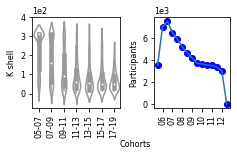

In [7]:
vote_df2 = pd.read_csv('Data_Wiki_Workshop/csv_files/data_filtered_count_above_5.csv', index_col=False)

votes=vote_df2[["user_id","timestamp"]]
groups=votes.groupby("user_id")

voter_list=[]
for i,group in nb.tqdm(groups):
    group_sort=group.sort_values(by="timestamp")
    voter_list.append(group_sort.iloc[0].tolist())

df_voter_list=pd.DataFrame(voter_list)


# Take cohorts bi-yearly

y = pd.to_datetime("2005")
set_group_biyears = []
while y < pd.to_datetime("2019"):
    print(y, y+ relativedelta(years=2))
    g= df_voter_list.loc[(pd.to_datetime(df_voter_list[1], unit="s") >= y) & (pd.to_datetime(df_voter_list[1], unit="s") < y+ relativedelta(years=2)),0].tolist()

    set_group_biyears.append(((y,y+ relativedelta(years=2)),g))
    y += relativedelta(years=2)




# Groups per shell is saved in file K_shell_group.json
with open('Data_Wiki_Workshop/json_files/K_shell_group.json') as f:
  k_shell_json = json.load(f)




# Prepare data
set_group_k_shell_biyears_hist = {}
len_list = []
for t,g in set_group_biyears:

    ss=[]
    for kk in k_shell_json.keys():

        j=pd.DataFrame(k_shell_json[kk]).astype(int)
        j=j[j[0].isin(g)]

        for jj in range(len(j)):
            ss.append(int(kk))

    len_list.append(len(ss))
    set_group_k_shell_biyears_hist[t]=ss    
        

# K-shell bi-yearly        

df_set_biyear_swplt=[]
for kk in set_group_k_shell_biyears_hist.keys():
    test_list =set_group_k_shell_biyears_hist[kk]
    for tt in test_list:
        df_set_biyear_swplt.append([int(tt),str(kk[0]).split(" ")[0].split("-")[0][-2:] + "-" + str(kk[1]).split(" ")[0].split("-")[0][-2:]])
    

df_set_swplt=pd.DataFrame(df_set_biyear_swplt, columns=['K shell', 'Year Range'])





df_all = pd.read_csv('Data_Wiki_Workshop/csv_files/data_filtered_count_above_5.csv', index_col=False)

group=df_all.groupby(by="discussion_id")

y = pd.to_datetime("2005")
x_labels = []

# Take cohort per year
num_user = []
date_times = []
grp_user = []
while y < pd.to_datetime("2020"):

    g= df_all.loc[(pd.to_datetime(df_all["timestamp"], unit="s") >= y) & (pd.to_datetime(df_all["timestamp"], unit="s") < y+ relativedelta(years=1))]

    num_user.append(len(g["user_id"].unique()))
    grp_user.append(list(g["user_id"].unique()))

    date_times.append(y)
    x_labels.append(y.strftime('%Y')[-2:])
    y += relativedelta(years=1)

## Plot

plt.rc('font',size=8)
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [2.2, 1.9]})

fig.subplots_adjust(left=.15, bottom=.05, right=.99, top=.97,wspace = 0.002)

sns.violinplot(x='Year Range', y='K shell', data=df_set_swplt,
                  color="white", fontsize='x-small', ax=axes[0])
axes[0].set_xlabel('')
# axes[0].gcf().autofmt_xdate(rotation=45)
axes[0].set_ylabel('K shell')
axes[0].tick_params(axis='x', rotation=90)
axes[0].ticklabel_format(axis='y', style='sci', scilimits=(2,2))


axes[1].plot(date_times,num_user, "bo")
axes[1].plot(date_times,num_user)

axes[1].set_xticklabels(x_labels)
axes[1].set_ylabel("Participants")
axes[1].tick_params(axis='x', rotation=90)
axes[1].ticklabel_format(axis='y', style='sci', scilimits=(3,3))

fig.text(0.57, 0.001, 'Cohorts', ha='center')
fig.set_size_inches(plot_width, plot_height)
plt.tight_layout()
plt.show()

In [217]:
fig.savefig('Plot_Wiki_Workshop/K_shell_and_Cohorts.pdf', dpi=150)

### Evolution of voting preference over time 

Figure 8. Evolution of voting preferences over time. The four shaded areas correspond to the 4 components of GMM fitted on voting trajectory deciles. The gray solid lines show the trajectories of a sample randomly-selected individuals. The black dashed lines correspond to the 95% confidence intervals of the average trajectory of each cluster.

/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)


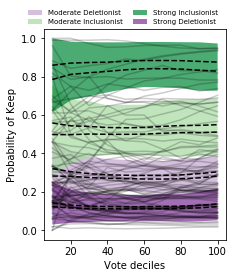

In [8]:
def PCA_processing(data):
    pca = PCA()
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents)
    principalDf

    return principalDf

# Groups per shell is saved in file K_shell_group.json
with open('Data_Wiki_Workshop/json_files/K_shell_group.json') as f:
  k_shell_json = json.load(f)

# Most active voters at the highest shell
active_nodes=k_shell_json[list(k_shell_json.keys())[-1]]

voters = pd.read_csv('csv_files/data_CMU/data_filtered_count_above_5.csv', index_col=False)
active_voters= voters[voters['user_id'].isin(active_nodes)].sort_index(by=['user_id','timestamp'])



#Calculate voting trajectory deciles
groups=active_voters.groupby('user_id')
df_data_vote_vs_ratio=[]
for name, group in nb.tqdm(groups):

    row = []
    row.append(name)
    for fr in range(1,11):
        group_frac= group.iloc[0:int(len(group)*fr*.1)]
        keep = len(group_frac.loc[group_frac['label']=='keep'])
        delete = len(group_frac.loc[group_frac['label']=='delete'])
        row.append(keep/(keep+delete))
    df_data_vote_vs_ratio.append(row)
data_v_r = pd.DataFrame(df_data_vote_vs_ratio,columns=["user_id","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])



# Dimension reduction before clustering
pca_data=PCA_processing(data_v_r[data_v_r.columns[1:]])
pca_data.head()
PCA1 = pca_data[pca_data.columns[:1]]




#






# Fitting GMM
cls = GMM(n_components=4, max_iter=1000, n_init=10).fit(PCA1)
data_v_r= data_v_r[data_v_r.columns[1:]]
labels_ = cls.predict(PCA1)
data_v_r['class']= labels_
data_v_r

#  BIC
mm=10
em_lb=[]
model_save = ''
for n in nb.tqdm(range(2,mm)):

    models = GMM(n_components=n, max_iter=1000, n_init=10).fit(PCA1)
    
    
    
    em_lb.append(models.bic(PCA1))
    

    




#Calcualte the confidence interval
data_std=np.array(data_v_r.groupby('class').std())
data_mean=np.array(data_v_r.groupby('class').mean())

dd=data_v_r.groupby('class').count()
data_sqrt=np.sqrt(np.array(dd))

upperbound1=data_mean + 2.58*data_std/data_sqrt
lowerbound1=data_mean - 2.58*data_std/data_sqrt

upperbound = []
lowerbound = []
for a,b in data_v_r.groupby('class'):
    upperbound.append(list(b.quantile(.1, axis = 0))[:-1])
    lowerbound.append(list(b.quantile(.9, axis = 0))[:-1])

   
#Plot    
plt.rc('font',size=10)
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)

color_num1 = ["#7b3294",  "#c2a5cf", "#a6dba0","#008837" ]   
color_num = {0: "#7b3294", 1: "#008837", 2: "#c2a5cf", 3: "#a6dba0", 4:"yellow"}
label_num = ["Strong Deletionist","Moderate Deletionist", "Moderate Inclusionist", "Strong Inclusionist"]
color_set = [color_num[num] for num in labels_]
label_set = [label_num[num] for num in labels_]

vote_percent = list(range(10,110,10))
fig = plt.figure() 
fig.subplots_adjust(left=.05, bottom=.05, right=.1, top=.97,wspace = 0.002)

r=rankdata(cls.means_)
for iii,b in data_v_r.groupby('class'):

    c=color_num1[int(r[iii])-1]
    labl = label_num[int(r[iii])-1]

    b= b.sample(frac=.075)

    plt.fill_between(vote_percent,  lowerbound[iii],upperbound[iii], facecolor=c, alpha=.7, label=labl)
    plt.plot(vote_percent,upperbound1[iii],c='black' ,linestyle = "--")
    plt.plot(vote_percent,lowerbound1[iii],c='black',linestyle = "--" )
    
    for a,row in b.iterrows():
        l1 = plt.plot(vote_percent,row[:10],c = 'black', alpha = .2 )   


# plt.ylim(0,1.5)
plt.legend(fontsize = 'x-small', frameon=False,bbox_to_anchor=(-0.12,.82,1.11,0.3), loc="upper left", 
           mode='expand', ncol=2)
plt.xlabel('Vote deciles')
plt.ylabel('Probability of Keep')

fig.set_size_inches(plot_width*1.1, plot_height+2)
plt.tight_layout()
plt.show()

In [619]:
fig.savefig('Plot_Wiki_Workshop/Evolution_of_voting_preference.pdf', dpi=150)

### Outcome Prediction Model

Figure 9. Average discussion outcome as a function of the observed (left) and predicted (right) rating.

No handles with labels found to put in legend.
/Users/swadtasnim002/.local/share/virtualenvs/Signed_Network-zk5vZyNY/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


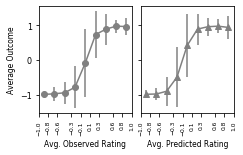

In [9]:
est_rate_res=pd.read_csv('Data_Wiki_Workshop/csv_files/Estimated_vs_Observed_Rating_Results', index_col=False)

plt.rc('font',size=8)
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=7.5)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,gridspec_kw={'hspace': 0, 'wspace': 0.10})
fig.subplots_adjust(left=.18, bottom=.25, right=.99, top=.97)

bins=np.round(np.linspace(-1,1, 10),1)
bins2=np.round(np.linspace(-1,1, 10),1)

ax1.plot(est_rate_res['interval_mid'],est_rate_res['average_outcome'],'bo',color='grey')
ax1.plot(est_rate_res['interval_mid'],est_rate_res['average_outcome'],color='grey')
ax1.errorbar(est_rate_res['interval_mid'],est_rate_res['average_outcome'], yerr=est_rate_res['std_outcome'],
             linestyle='None', marker='None',color='grey')

ax2.plot(est_rate_res['interval_mid2'],est_rate_res['average_outcome2'],'^',color='grey')
ax2.plot(est_rate_res['interval_mid2'],est_rate_res['average_outcome2'],color='grey')
ax2.errorbar(est_rate_res['interval_mid2'],est_rate_res['average_outcome2'], yerr=est_rate_res['std_outcome2'], 
             linestyle='None', marker='None',color='grey')

plt.legend(fontsize = 'x-small', frameon=False)

ax1.set(xlabel='Avg. Observed Rating', ylabel="Average Outcome", xticks=bins)
ax1.tick_params(axis='x', rotation=90)
ax2.set(xlabel='Avg. Predicted Rating', xticks=bins2) 
ax2.tick_params(axis='x', rotation=90)
fig.set_size_inches(plot_width, plot_height)
plt.tight_layout()
plt.show()


In [322]:
fig.savefig('Plot_Wiki_Workshop/Average_discussion_outcome.pdf', dpi=150)

Figure 10: Performance of the latent factor model for rating prediction, as a function of the binarization threshold. Precision and recall are weighted by the number of true instances for each label (positive and negative)

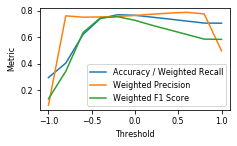

In [10]:
all_result=pd.read_csv('Data_Wiki_Workshop/csv_files/Result_kfold.csv', index_col=False)

res=all_result.sort_values(by='Outer_k_fold').groupby(['threshold',]).mean().reset_index()
res

plt.rc('font',size=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

plt.plot(res['threshold'],res['est_rate_acc'],label='Accuracy / Weighted Recall')
plt.plot(res['threshold'],res['est_rate_w_precision'], label = "Weighted Precision")
plt.plot(res['threshold'],res['est_rate_w_f1_score'], label = "Weighted F1 Score")

plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.legend(loc="lower right")

fig.set_size_inches(plot_width, plot_height)
plt.tight_layout()
plt.show()

In [8]:
fig.savefig('Plot_Wiki_Workshop/Latent_Factor_Metric.pdf', dpi=150)

Figure 11: Left: Performance of the outcome prediction model as a function of the binarization threshold. Precision and recall are weighted by the number of true instances for each label (positive and negative). The dashed lines (all overlapping) represent the metric of the observed ratings. Right:ROC curve of the stacked model for the outcome prediction task for different rating features (Pr. = predicted, Ob. = observed). The number in parenthesis is the AUC.

dict_keys(['-1.0', '-0.8', '-0.6000000000000001', '-0.40000000000000013', '-0.20000000000000018', '-2.220446049250313e-16', '0.19999999999999973', '0.3999999999999997', '0.5999999999999996', '0.7999999999999996', '0.9999999999999996'])


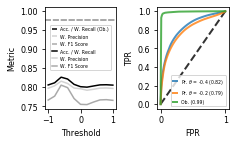

In [11]:
with open('Data_Wiki_Workshop/ROC_Est.pickle', 'rb') as handle:
    roc_json2 = pickle.load(handle)
print(roc_json2.keys())
roc_json2['-0.40000000000000013']

with open('Data_Wiki_Workshop/ROC_Ob.pickle', 'rb') as handle:
    roc_json3 = pickle.load(handle)
roc_json3.keys()

plt.rc('font',size=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

fig, axes = plt.subplots(nrows=1, ncols=2)

fig.subplots_adjust(left=.15, bottom=.05, right=.99, top=.97,wspace = 0.002)

axes[0].axhline(res.iloc[0]['outcome_with_observed_rate_acc'], label='Acc. / W. Recall (Ob.)',
                linestyle='--', color='black')
axes[0].axhline(res.iloc[0]['outcome_with_observed_rate_w_precision'], label = "W. Precision",
                linestyle='--', color='lightgrey')
axes[0].axhline(res.iloc[0]['outcome_with_observed_rate_w_f1_score'], label = "W. F1 Score",
                linestyle='--', color='darkgrey')

axes[0].plot(res['threshold'],res['outcome_with_est_rate_acc'],label='Acc. / W. Recall', color='black')
axes[0].plot(res['threshold'],res['outcome_with_est_rate_w_precision'], label = "W. Precision",
             color='lightgrey')
axes[0].plot(res['threshold'],res['outcome_with_est_rate_w_f1_score'], label = "W. F1 Score", color='darkgrey')
y=axes[0].get_ylim()
axes[0].set_ylim(y[0],y[1]+.025)
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Metric")
axes[0].legend(fontsize='xx-small', frameon=True, loc='center',handlelength=1, bbox_to_anchor=(.5,.6) )


axes[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
        label='', alpha=.8)
auc_est_list = all_result.groupby('threshold').std()['auc_est']
auc_ob_list = all_result.groupby('threshold').std()['aucs_ob']
mean_fpr = np.linspace(0, 1, 100)

for tp,au in list(zip(list(roc_json2.keys()),auc_est_list)):
    if float(tp) > -.6 and float(tp) < -.10:
        tprs_est = roc_json2[tp]
        mean_tpr = np.mean(tprs_est, axis=0)

        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = au
        axes[1].plot(mean_fpr, mean_tpr,
                label=r'Pr. $\theta$ = %0.1f (%0.2f)' % (float(tp),mean_auc),
                lw=2, alpha=.8)
        
tprs_est = roc_json3['-2.220446049250313e-16']
mean_tpr = np.mean(tprs_est, axis=0)

mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = list(auc_ob_list)[0]
axes[1].plot(mean_fpr, mean_tpr,
        label=r'Ob. (%0.2f)' % (mean_auc),
        lw=2, alpha=.8)


axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].legend(fontsize='xx-small', frameon=True, loc="lower right", handlelength=1 )
fig.set_size_inches(plot_width, plot_height)
plt.tight_layout()
plt.show()

In [21]:
fig.savefig('Plot_Wiki_Workshop/Outcome_Prediction_Metric_ROC.pdf', dpi=150)